In [1]:
#Libraries necessary for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
from pandas import concat
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

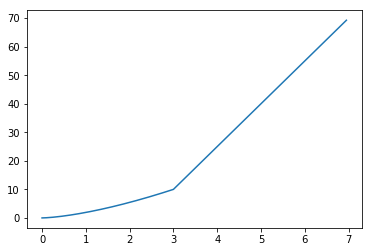

In [32]:
def river_section(H,l,h): # a simple model for the section of a river of depth H and width l
    # returns the surface of the section when the water height is h
    if h<=H:
        return(2*l*h**(1.5)/(3*H**0.5))
    else:
        return( l*H*2/3 + 3*(h-H)*l)

X = np.arange(0,7,0.05)
Y = [river_section(3,5,x) for x in X]

plt.plot(X,Y)

#-------- Getting area section from data

def data_to_section(data): # turns the 3D point array into an array of 2D points
    # That is seeing the data as the section of the river
    
    section = []
    for point in data: # s is the distance of to the origin
        s = (point[0]**2 + point[1]**2)**0.5
        section.append([s,point[2]])
    return section

def section_to_function(s, section): # linear interpolation of the height of the section
    # s is the curvilinear abscissa and the function returns the height at this position
    interval = [section[0][0], section[-1][0]]
    
    
    if s<interval[0] or s>interval[1]:
        return("Error: value out of range")
    else:
        for k in range(len(section)):
            if section[k][0] <= s and section[k+1][0] >= s:
                z = section[k][0] + (s - section[k][0])*(section[k+1][1]-section[k][1])/(section[k+1][0]-section[k][0])
        
        return z

    
def keep_negative(x):
    if x >= 0:
        return 0
    else:
        return -x

    
def river_bottom(section, river_pos): # returns the bottom of the river
    # that is minimum of the section height within the interval river_pos(a list of two numbers)
    bottom = section[river_pos[0]][1]
    
    for k in range(len(section)):
        if section[k][0] >= river_pos[0] and section[k][0]<= river_pos[1]:
            if section[k][1] <= bottom:
                bottom = section[k][1]
    
    return bottom

# bottom = river_bottom(section, river_pos)

def submerged_section(s, section, h): # return the section height below the river water level h
    return keep_negative(section_to_function(s,section)- h - bottom)
    
            

def section_to_area(section, river_pos, h):
    interval = [section[0][0], section[-1][0]]
    
    height_treshold = min(section[river_pos[0]][1],section[river_pos[1]][1])
    
    if h > height_treshold:
        A = quad(submerged_section,interval[0],interval[1], args=(section, h))
    else:
        A = quad(submerged_section,river_pos[0],river_pos[1], args=(section, h))
    
    return A
    
    

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

def rating_curve(Q,h): # Makes a polynomial relationship of third degree between Q and h (two lists or array)
    # the water flows Q is expressed as a function of the water heights h
    # the function returns a list with the coefficients of said polynomial
    
    poly = PolynomialFeatures(3)
    poly_array = poly.fit_transform(h)
    
    regr = linear_model.LinearRegression()
    regr.fit(poly_array,Q)
    
    return(regr.coef_)

def array_to_polynomial(l,h): # function to use the regression coefficient from rating_curve
    # evaluate the associated polynomial to l at a given number h
    S = 0
    k=0
    for coef in l:
        S += coef*h**k
        k += 1
    return S

In [ ]:

def travel_time(L,H,l,Q,h): # returns an estimated travel time T(h) from all the parameters
    coef = rating_curve(Q,h)
    
    T = []
    for height in h:
        T.append(L*river_section(H,l,height)/array_to_polynomial(coef,height))
    
    return(T)

def exp_regression(X,Y): # predicting Y from X using exponential regression Y = a*X**b
    # X and Y are expected to be two arrays
    
    W = np.log(Y)
    V = np.log(X)
    poly = PolynomialFeatures(1)
    poly_array = poly.fit_transform(V)
    
    regr = linear_model.LinearRegression()
    regr.fit(poly_array,Z)
    
    l = np.exp(regr.coef_)
    
    return(l)

def array_to_exp(l,h):
    return(np.exp(l[0])*h**l[1])
    
# to do: plotting the travel time as a function of h and finding a mathematical model from it (although the
# exponential regression should do the trick)

In [ ]:
#---- Work on peak clusters

def maximums(df, delta): 
    # return a dataframe including the water height peaks of each sensor
    # df is the data sample and delta is a parameter used to determine what's a peak or not
    # a value is considered a peak at t0 if all the values in [t0 - delta*T,..., to,..., t0 + delta*T] are 
    # below the one at t0
    
    dff = pd.DataFrame()
    dff = df.copy()
    
    n = len(dff.index)
    for col in dff:
        dff[col][n-1]=0 # cannot be a maximum
        
        increasing = True  
        for k in range(n-1):
            max_check= False  # value to mark a value as a maximum or not
            
            
            if increasing:
                if df[col][k+1]<df[col][k]: # if the height drops
                    increasing = False

                    if delta<=k and k+delta<n: # we check if the surrounding values are the below the current one
                        max_check = True
                        #print(col +": " + str(df[col][k]))
                        for i in range(1,delta+1):
                            if df[col][k-i] >= df[col][k] or df[col][k+i]>df[col][k]: 
                                max_check = False
            else: # if the heights are dropping, we simply check if the water rises again
                if df[col][k+1]>=df[col][k]:
                    increasing = True
            
            if not max_check: # we set the value to 0 if the value is not a maximum
                dff[col][k] = 0
                
    dff = dff[(dff.T != 0).any()] # removes the rows with no local maximum
    
    return dff
                          
            
            
    
def rises(df):
    # will return a dataframe including the rises period for all sensors
    # there needs to be activities in delta followings rows for all sensors for it to be kept
    
    dff = maximums(df,4) # check if peaks are local maximums within a range of one hour
    delta = len(dff.columns)
    
    msk = np.array([False for k in range(len(dff.index))]) # mask used to keep the wanted rows
    rise_memory = [0 for k in range(len(dff.columns))] # stores the recent activity of each sensor
    
    k=0 # value of each row index
    for idx, row in dff.iterrows():
        
        # we set the activity of the column to delta if a peak happens in the row
        # we decrease it by 1 otherwise with a threshold of 0
        i = 0
        for col in dff:
            if row[col] != 0:
                rise_memory[i] = delta
            elif rise_memory[i] > 0:
                rise_memory[i] -= 1
            i += 1
        
        # if activities are within all values of memory rise then we consider that a water rise happened
        rise_check = True
        for memory in rise_memory:
            if memory == 0:
                rise_check = False
        
        # then all the according values of the mask are set to True
        if rise_check:
            for j in range(max(0,k-delta),k+1):
                msk[j] = True
        
        k += 1
    
    dff = dff[msk]
    
    return dff
            


In [10]:
def integrand(x,a,b):
    return a*x**2 + b

a=2
b=1
I = quad(integrand,0,1, args=(a,b))

print(I)

(1.6666666666666667, 1.8503717077085944e-14)
